In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from itertools import product
from collections import defaultdict
import shap
from scipy.signal import correlate
from copy import deepcopy

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
kf = StratifiedShuffleSplit(n_splits=5)

In [5]:
series = pd.read_csv('train.csv')
series.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [6]:
labels = pd.read_csv('train_labels.csv', index_col=['sequence'])
labels.head()

,state
sequence,
0,0
1,1
2,1
3,1
4,1


some ideas from https://www.kaggle.com/code/dmitryuarov/tps-sensors-2xlstm-xgb-auc-0-976#XGB

quantile needs a decoration: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function

In [7]:
def quantile(q):
    def quantile_(x):
        return np.quantile(x,q)
    quantile_.__name__ = f"quantile_{str(q)}"
    return quantile_

In [43]:
def prep(df):
    result = pd.DataFrame()
    result['sequence'] = df['sequence'].unique()
    result = result.merge(df[['sequence','subject']], how='left',on='sequence')
    
    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('sequence').agg({sensor:['mean','std','median','mad',
                                                      'min','max','sum','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='sequence')
        print(result.columns)

    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('subject').agg({sensor:['mean','std','median','mad',
                                                      'min','max','sum','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_subject_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='subject')
        print(result.columns)
    
    
    result = result.drop_duplicates()
    result.index = np.arange(len(result))
    return result

In [44]:
train = prep(series)

doing sensor_00
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9'],
      dtype='object')
doing sensor_01
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9'],
      dtype='object')
doing sensor_02
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9', 'sensor_02_mean', 'sensor_02_std',
       'sensor_02_median', 'sensor_02_mad', 'sensor_02_min', 'sensor_02_max',
       'sensor_02_sum', 'sensor_02_skew', 'sensor_02_quantile_0.1',
       'sensor_02_quantile_0.9', 'sensor_03_mean', 'sensor_03_std',
       'sensor_03_median', 'sensor_03_mad', 'sensor_03_min', 'sensor_03_max',
       'sensor_03_sum', 'sensor_03_skew', 'sensor_03_quantile_0.1',
       'sensor_03_quantile_0.9', 'sensor_04_mean', 'sensor_04_std',
       'sensor_04_median', 'sensor_04_mad', 'sensor_04_min', 'sensor_04_max',
 

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_08_subject_mean', 'sensor_08_subject_std',
       'sensor_08_subject_median', 'sensor_08_subject_mad',
       'sensor_08_subject_min', 'sensor_08_subject_max',
       'sensor_08_subject_sum', 'sensor_08_subject_skew',
       'sensor_08_subject_quantile_0.1', 'sensor_08_subject_quantile_0.9'],
      dtype='object', length=222)
doing sensor_09
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_09_subject_mean', 'sensor_09_subject_std',
       'sensor_09_subject_median', 'sensor_09_subject_mad',
       'sensor_09_subject_min', 'sensor_09_subject_max',
       'sensor_09_subject_sum', 'sensor_09_subject_skew',
       'sensor_0

In [45]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_subject_mean,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_sum,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,-0.078774,20.293662,-0.254476,12.579934,-312.621910,213.832481,-491.551151,-0.709353,-18.520588,19.573359
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,-0.707871,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,-0.707871,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.001263,0.533071,-0.012788,0.349181,-3.136829,3.487639,6.289855,0.321107,-0.538107,0.558227
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.000280,0.318285,0.003410,0.216635,-2.805200,2.629156,3.347826,-0.224039,-0.394288,0.387937


In [46]:
train['label'] = labels['state']

In [47]:
series.columns[3:]

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12'],
      dtype='object')

In [34]:
template = pd.read_csv('template_sensor_04.csv').values

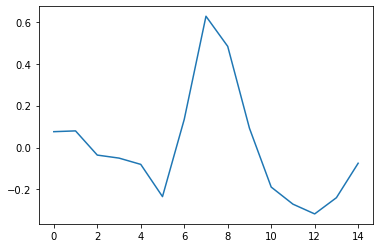

In [28]:
plt.plot(template.T);

In [30]:
tmp = series[series['sequence']==0]['sensor_04'].values
tmp

array([-1.00465964,  0.16249532,  0.47367847, -0.563287  ,  0.39857873,
        0.46973569, -0.59696422, -0.05998317, -0.07171799, -0.75522067,
        0.38657898,  0.9718863 , -0.29534971, -0.34096434,  0.67935731,
        0.16001745, -0.70331006,  0.26573993,  0.29422765, -0.86120808,
       -0.04739122,  0.64357624, -0.32019075, -0.28190064,  0.56617005,
       -0.01472697, -0.77937601,  0.42042763,  0.00615572,  0.36945206,
        0.4990182 , -0.79483543, -0.47579791,  0.63547251, -0.07489714,
       -0.59948884,  0.61622616,  0.59515646, -0.61611707, -0.83036716,
        0.5812087 ,  0.48253023, -0.62143124,  0.3047625 ,  0.50612455,
       -0.83487096, -0.03218115,  0.71778768, -0.40175789, -0.80529236,
        0.66142002,  0.65317604, -0.95027116,  0.00335058,  0.96074367,
       -0.58000873, -1.60439783,  0.18320658,  0.14497881, -1.18172609])

In [31]:
tmp -= np.mean(tmp)
power = np.sqrt(np.sum(np.power(tmp,2)))
tmp /= power

In [36]:
template.shape, tmp.shape

((15, 1), (60,))

In [37]:
correlate(template.reshape(-1), tmp, mode='valid')

array([-0.00863899,  0.13412693,  0.20537601, -0.04505788, -0.10959376,
        0.07459723,  0.00534459, -0.12526843,  0.01637076,  0.07617632,
       -0.01962284,  0.05256459,  0.12451999, -0.07337157, -0.20229659,
        0.00725265,  0.12749248, -0.00096276,  0.02502201,  0.08944679,
       -0.07755411, -0.16185793, -0.02973512,  0.07215983,  0.13130308,
        0.07530962, -0.07688385, -0.06187012,  0.01717632, -0.04030151,
       -0.028887  ,  0.10991204,  0.03497222, -0.11394318, -0.02143803,
        0.02965154, -0.07983176, -0.01844837,  0.10429966, -0.00025044,
       -0.02626442,  0.15569956,  0.12526688, -0.05235461, -0.08563541,
       -0.13424569])

In [48]:
def prep_corr(df, dfout):
    sensors = df.columns[3:]
    for sensor in sensors:
        X = df[sensor].values.reshape(-1,60).copy()
        mean = np.mean(X, axis=1)[:, np.newaxis]
        X = X - mean
        power = np.sum(np.power(X, 2), axis=1)
        power[power==0] = 1
        power = np.sqrt(power)[:,np.newaxis]
        X = X / power
        
        template = pd.read_csv('template_' + sensor + '.csv').values.reshape(1,-1)
        dfout[sensor+'_corr'] = np.max(correlate(template, X, mode='valid')[::-1], axis=1)

In [49]:
prep_corr(series, train)

In [50]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_03_corr,sensor_04_corr,sensor_05_corr,sensor_06_corr,sensor_07_corr,sensor_08_corr,sensor_09_corr,sensor_10_corr,sensor_11_corr,sensor_12_corr
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0.234139,0.205376,0.311452,0.305719,0.198836,0.442239,0.283562,0.269030,0.329348,0.227136
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0.477971,0.441894,0.320698,0.383905,0.538582,0.367945,0.573946,0.595769,0.320992,0.454433
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0.402786,0.530354,0.484730,0.419941,0.320479,0.409183,0.365350,0.577366,0.327406,0.357210
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.465588,0.242902,0.450173,0.307201,0.517353,0.418139,0.484548,0.490918,0.358366,0.509921
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.282975,0.146067,0.267310,0.404221,0.257423,0.344855,0.411843,0.136277,0.393332,0.280330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0.350901,0.151991,0.578738,0.149248,0.536950,0.356715,0.237311,0.262241,0.333007,0.259081
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0.282149,0.157277,0.285754,0.286795,0.350339,0.323952,0.174574,0.139471,0.296125,0.496935
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0.229817,0.283425,0.327730,0.375871,0.293960,0.450384,0.200095,0.234260,0.298284,0.247077
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0.553525,0.365728,0.262400,0.462162,0.445991,0.578244,0.244693,0.301672,0.771173,0.296740


### do a brute force xgboost

In [51]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values

In [52]:
X.shape, y.shape

((25968, 273), (25968,))

In [62]:
def gridsearch_xgboost(params, X, y, obj="binary:logistic"):
    ''' the params include both the fit and the booster params '''
    
    param_names, param_vals = zip(*list(params.items()))
    id_booster, id_fit = [], []
    for idx, name in enumerate(param_names):
        if (name=='early_stopping_rounds'):
            id_fit.append(idx)
        else:
            id_booster.append(idx)
    
    best_test_score = 0.0
    for val_combination in product(*param_vals):
        param_fit, param_booster = {}, {}
        param_fit['eval_metric'] = 'auc'
        for idx in id_fit:
            param_fit[param_names[idx]] = val_combination[idx]
        for idx in id_booster:
            param_booster[param_names[idx]] = val_combination[idx]
        print(f"param_fit: {param_fit}")
        print(f"param_booster: {param_booster}")
        
        clf = XGBClassifier(**param_booster, objective=obj, use_label_encoder=False)
        result = defaultdict(list)
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            param_fit['eval_set'] = [(X_test, y_test)]            
            clf.fit(X_train, y_train, **param_fit, verbose=True)
            if hasattr(clf, 'best_ntree_limit'):
                result['ntree'].append(clf.best_ntree_limit)
            else:
                result['ntree'].append(clf.n_estimators)            
            result['score'].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
            print(f'stop at {result["ntree"][-1]}, score={result["score"][-1]}')
            break

        mean_test_score = np.mean(result['score'])
        print(f"mean_test_score={mean_test_score}")
        if mean_test_score > best_test_score:
            best_test_score = mean_test_score
            best_param_booster = param_booster
            best_param_booster['n_estimators'] = np.int32(np.mean(result['ntree']))
            dum_clf = deepcopy(clf)
    
    return best_param_booster, dum_clf

In [59]:
params = {'gamma': [0],
          'max_depth': [6],
          'min_child_weight': [0.0],
          'n_estimators': [10000],
          'early_stopping_rounds': [50],
          'learning_rate': [0.4]}

In [63]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4}
[0]	validation_0-auc:0.80235
[1]	validation_0-auc:0.83002
[2]	validation_0-auc:0.84558
[3]	validation_0-auc:0.85593
[4]	validation_0-auc:0.86111
[5]	validation_0-auc:0.86964
[6]	validation_0-auc:0.87691
[7]	validation_0-auc:0.88118
[8]	validation_0-auc:0.88516
[9]	validation_0-auc:0.88843
[10]	validation_0-auc:0.89080
[11]	validation_0-auc:0.89373
[12]	validation_0-auc:0.89499
[13]	validation_0-auc:0.89666
[14]	validation_0-auc:0.89874
[15]	validation_0-auc:0.90003
[16]	validation_0-auc:0.90162
[17]	validation_0-auc:0.90401
[18]	validation_0-auc:0.90604
[19]	validation_0-auc:0.90616
[20]	validation_0-auc:0.90719
[21]	validation_0-auc:0.90944
[22]	validation_0-auc:0.91032
[23]	validation_0-auc:0.91070
[24]	validation_0-auc:0.91109
[25]	validation_0-auc:0.91187
[26]	validation_0-auc:0.91285
[27]	validation_0-auc:0

[263]	validation_0-auc:0.93519
[264]	validation_0-auc:0.93515
[265]	validation_0-auc:0.93533
[266]	validation_0-auc:0.93532
[267]	validation_0-auc:0.93521
[268]	validation_0-auc:0.93527
[269]	validation_0-auc:0.93528
[270]	validation_0-auc:0.93517
[271]	validation_0-auc:0.93518
[272]	validation_0-auc:0.93525
[273]	validation_0-auc:0.93520
[274]	validation_0-auc:0.93528
[275]	validation_0-auc:0.93525
[276]	validation_0-auc:0.93511
[277]	validation_0-auc:0.93522
[278]	validation_0-auc:0.93526
[279]	validation_0-auc:0.93539
[280]	validation_0-auc:0.93530
[281]	validation_0-auc:0.93528
[282]	validation_0-auc:0.93529
[283]	validation_0-auc:0.93527
[284]	validation_0-auc:0.93522
[285]	validation_0-auc:0.93522
[286]	validation_0-auc:0.93524
[287]	validation_0-auc:0.93519
[288]	validation_0-auc:0.93521
[289]	validation_0-auc:0.93522
[290]	validation_0-auc:0.93525
[291]	validation_0-auc:0.93515
[292]	validation_0-auc:0.93517
[293]	validation_0-auc:0.93524
[294]	validation_0-auc:0.93528
[295]	va

[528]	validation_0-auc:0.93819
[529]	validation_0-auc:0.93824
[530]	validation_0-auc:0.93824
[531]	validation_0-auc:0.93825
[532]	validation_0-auc:0.93830
[533]	validation_0-auc:0.93827
[534]	validation_0-auc:0.93829
[535]	validation_0-auc:0.93830
[536]	validation_0-auc:0.93832
[537]	validation_0-auc:0.93834
[538]	validation_0-auc:0.93833
[539]	validation_0-auc:0.93831
[540]	validation_0-auc:0.93834
[541]	validation_0-auc:0.93837
[542]	validation_0-auc:0.93834
[543]	validation_0-auc:0.93833
[544]	validation_0-auc:0.93832
[545]	validation_0-auc:0.93835
[546]	validation_0-auc:0.93830
[547]	validation_0-auc:0.93833
[548]	validation_0-auc:0.93832
[549]	validation_0-auc:0.93830
[550]	validation_0-auc:0.93832
[551]	validation_0-auc:0.93829
[552]	validation_0-auc:0.93830
[553]	validation_0-auc:0.93833
[554]	validation_0-auc:0.93837
[555]	validation_0-auc:0.93836
[556]	validation_0-auc:0.93843
[557]	validation_0-auc:0.93842
[558]	validation_0-auc:0.93845
[559]	validation_0-auc:0.93848
[560]	va

In [64]:
shap_values = shap.TreeExplainer(dum_clf).shap_values(shap.sample(X,1000))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


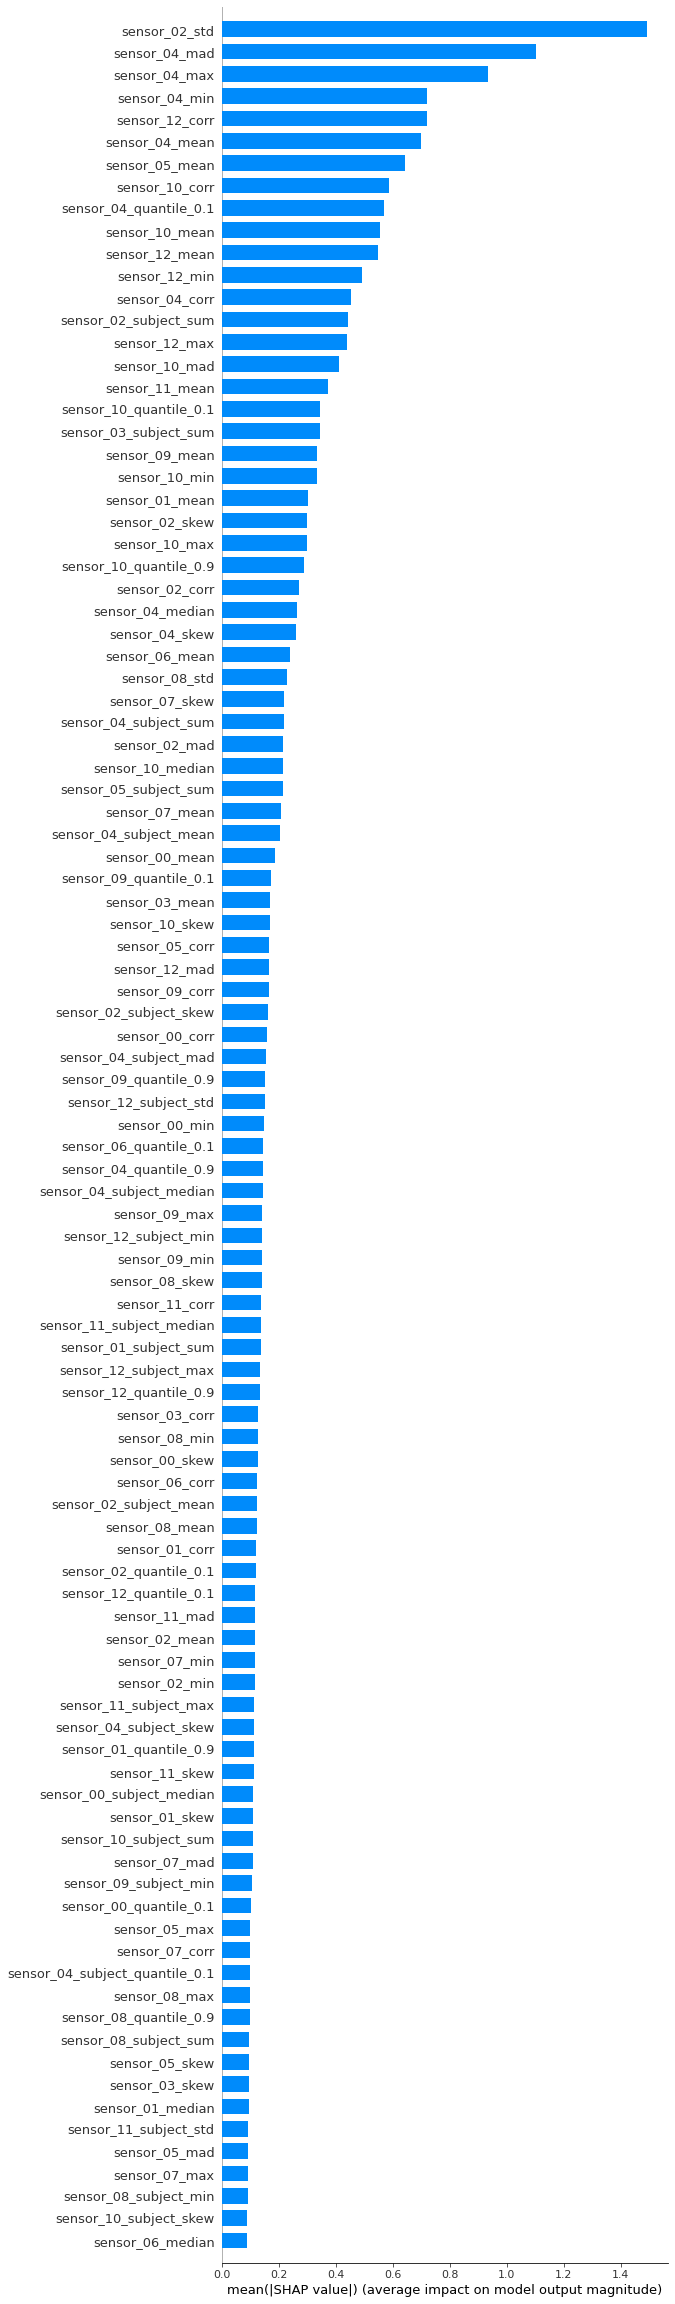

In [65]:
shap.summary_plot(shap_values, plot_type='bar', \
                  features=train.drop(columns=['sequence','subject','label']).columns, \
                  max_display=100)

In [94]:
def prep_corr_tmp(df, dfout):
    sensors = df.columns[3:]
    for sensor in ['sensor_04']:
        X = df[sensor].values.reshape(-1,60).copy()
        mean = np.mean(X, axis=1)[:, np.newaxis]
        X = X - mean
        power = np.sum(np.power(X, 2), axis=1)
        power[power==0] = 1
        power = np.sqrt(power)[:,np.newaxis]
        X = X / power
        
        corr = pd.read_csv('template_corr.csv').values.reshape(-1,)
        dfout[sensor+'_corr1'] = corr

In [95]:
prep_corr_tmp(series, train)

In [96]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_04_corr,sensor_05_corr,sensor_06_corr,sensor_07_corr,sensor_08_corr,sensor_09_corr,sensor_10_corr,sensor_11_corr,sensor_12_corr,sensor_04_corr1
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0.199336,0.311452,0.305719,0.198836,0.442239,0.283562,0.269030,0.329348,0.227136,0.166180
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0.334366,0.320698,0.383905,0.538582,0.367945,0.573946,0.595769,0.320992,0.454433,0.400776
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0.637344,0.484730,0.419941,0.320479,0.409183,0.365350,0.577366,0.327406,0.357210,0.340781
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.261650,0.450173,0.307201,0.517353,0.418139,0.484548,0.490918,0.358366,0.509921,0.178768
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.279822,0.267310,0.404221,0.257423,0.344855,0.411843,0.136277,0.393332,0.280330,0.177860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0.243359,0.578738,0.149248,0.536950,0.356715,0.237311,0.262241,0.333007,0.259081,0.186671
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0.193162,0.285754,0.286795,0.350339,0.323952,0.174574,0.139471,0.296125,0.496935,0.269525
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0.305936,0.327730,0.375871,0.293960,0.450384,0.200095,0.234260,0.298284,0.247077,0.583790
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0.358992,0.262400,0.462162,0.445991,0.578244,0.244693,0.301672,0.771173,0.296740,0.437540


In [97]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4}
[0]	validation_0-auc:0.82478
[1]	validation_0-auc:0.84351
[2]	validation_0-auc:0.85851
[3]	validation_0-auc:0.86775
[4]	validation_0-auc:0.87804
[5]	validation_0-auc:0.88453
[6]	validation_0-auc:0.89319
[7]	validation_0-auc:0.89891
[8]	validation_0-auc:0.90177
[9]	validation_0-auc:0.90521
[10]	validation_0-auc:0.90800
[11]	validation_0-auc:0.91026
[12]	validation_0-auc:0.91233
[13]	validation_0-auc:0.91247
[14]	validation_0-auc:0.91603
[15]	validation_0-auc:0.91755
[16]	validation_0-auc:0.91798
[17]	validation_0-auc:0.91979
[18]	validation_0-auc:0.92021
[19]	validation_0-auc:0.92234
[20]	validation_0-auc:0.92319
[21]	validation_0-auc:0.92387
[22]	validation_0-auc:0.92426
[23]	validation_0-auc:0.92491
[24]	validation_0-auc:0.92559
[25]	validation_0-auc:0.92672
[26]	validation_0-auc:0.92710
[27]	validation_0-auc:0

[263]	validation_0-auc:0.94551
[264]	validation_0-auc:0.94561
[265]	validation_0-auc:0.94567
[266]	validation_0-auc:0.94567
[267]	validation_0-auc:0.94556
[268]	validation_0-auc:0.94559
[269]	validation_0-auc:0.94570
[270]	validation_0-auc:0.94571
[271]	validation_0-auc:0.94582
[272]	validation_0-auc:0.94581
[273]	validation_0-auc:0.94584
[274]	validation_0-auc:0.94588
[275]	validation_0-auc:0.94594
[276]	validation_0-auc:0.94596
[277]	validation_0-auc:0.94599
[278]	validation_0-auc:0.94605
[279]	validation_0-auc:0.94610
[280]	validation_0-auc:0.94608
[281]	validation_0-auc:0.94606
[282]	validation_0-auc:0.94614
[283]	validation_0-auc:0.94612
[284]	validation_0-auc:0.94617
[285]	validation_0-auc:0.94629
[286]	validation_0-auc:0.94635
[287]	validation_0-auc:0.94623
[288]	validation_0-auc:0.94611
[289]	validation_0-auc:0.94615
[290]	validation_0-auc:0.94625
[291]	validation_0-auc:0.94621
[292]	validation_0-auc:0.94619
[293]	validation_0-auc:0.94614
[294]	validation_0-auc:0.94618
[295]	va

In [102]:
shap_values = shap.TreeExplainer(dum_clf).shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


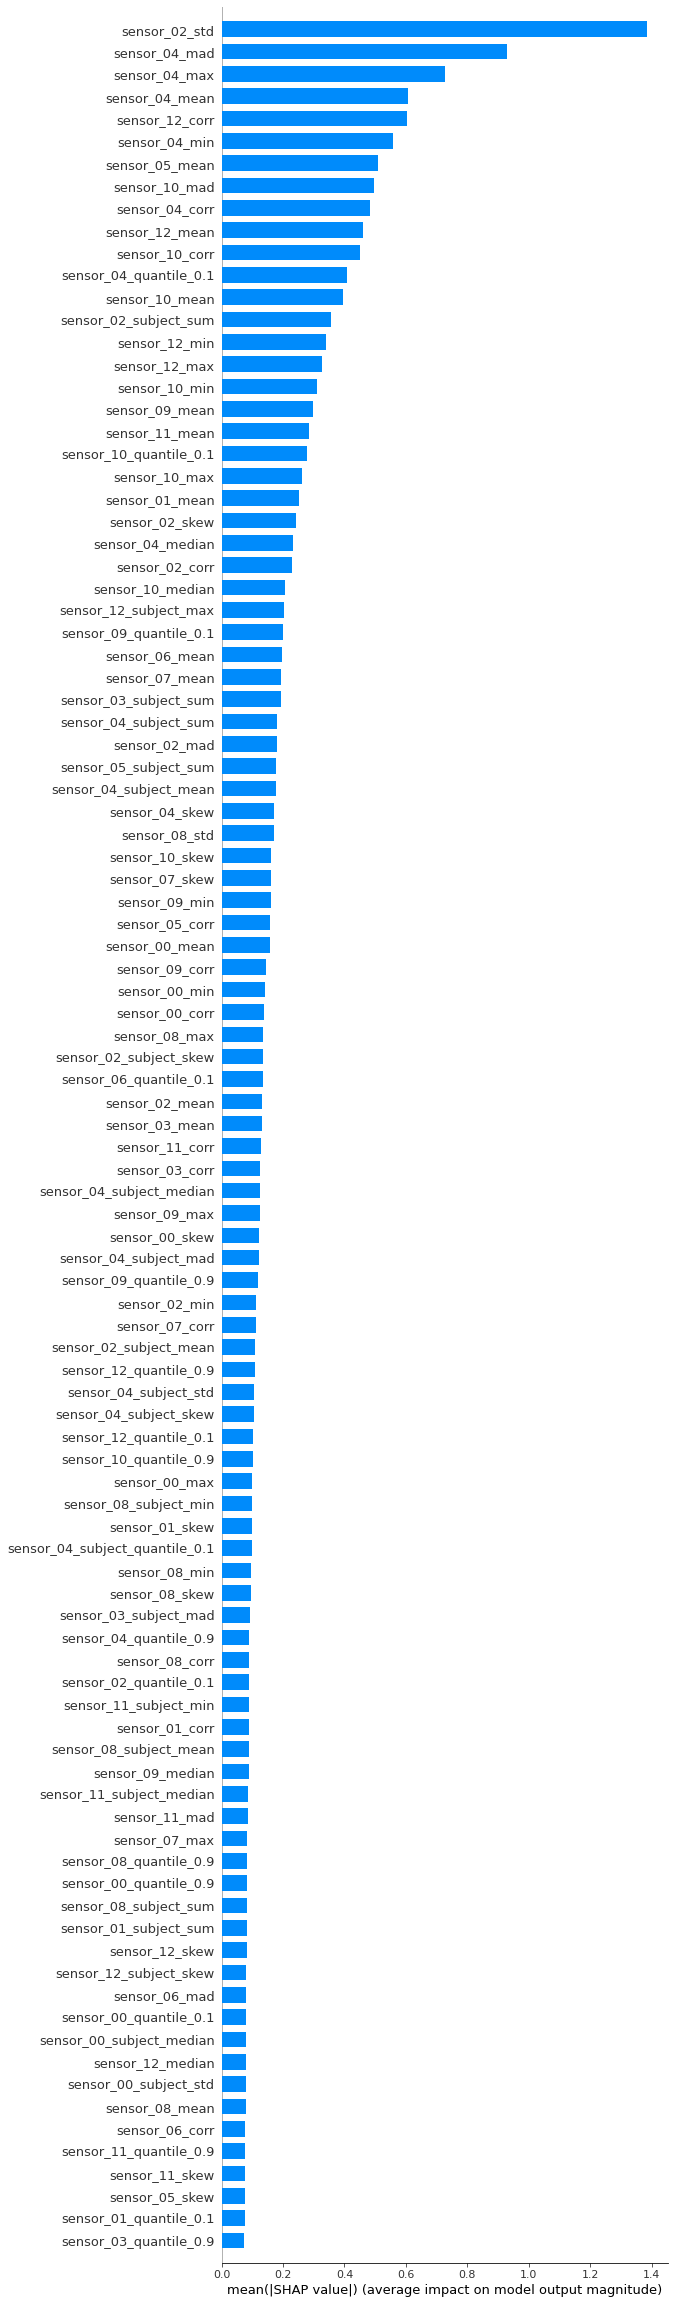

In [103]:
shap.summary_plot(shap_values, plot_type='bar', \
                  features=train.drop(columns=['sequence','subject','label']).columns, \
                  max_display=100)

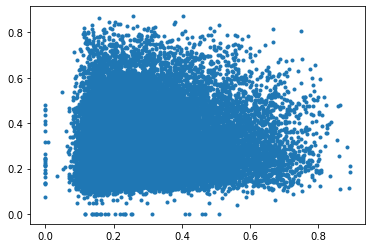

In [81]:
w1 = pd.read_csv('template_corr.csv').values
w2 = pd.read_csv('template_corr_sensor_04.csv').values
plt.plot(w1,w2,'.')

In [86]:
id0, id1 = (labels['state']==0), (labels['state']==1)

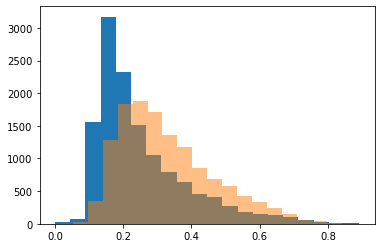

In [90]:
plt.hist(w1[id0],bins=20);
plt.hist(w1[id1],bins=20,alpha=0.5);

In [93]:
np.median(w1[id0]) - np.median(w1[id1]), np.median(w2[id0]) - np.median(w2[id1])

(-0.09194519283703378, -0.09718503622447594)

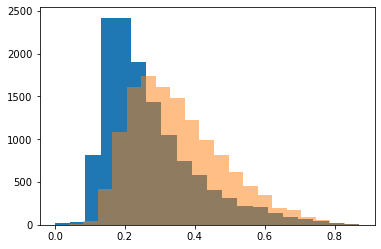

In [91]:
plt.hist(w2[id0],bins=20);
plt.hist(w2[id1],bins=20,alpha=0.5);

In [104]:
from sklearn.linear_model import LogisticRegression

In [115]:
from sklearn.metrics import accuracy_score

In [117]:
clf = LogisticRegression()
clf.fit(w1, labels.values[:,0])
accuracy_score(labels.values[:,0], clf.predict(w1))

0.6243068391866913

In [119]:
clf = LogisticRegression()
clf.fit(w2, labels.values[:,0])
accuracy_score(labels.values[:,0], clf.predict(w2))

0.6328558225508318

### try again with clf ooutput (template_run2.py)

In [121]:
train = prep(series)

doing sensor_00
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9'],
      dtype='object')
doing sensor_01
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9'],
      dtype='object')
doing sensor_02
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9', 'sensor_02_mean', 'sensor_02_std',
       'sensor_02_median', 'sensor_02_mad', 'sensor_02_min', 'sensor_02_max',
       'sensor_02_sum', 'sensor_02_skew', 'sensor_02_quantile_0.1',
       'sensor_02_quantile_0.9', 'sensor_03_mean', 'sensor_03_std',
       'sensor_03_median', 'sensor_03_mad', 'sensor_03_min', 'sensor_03_max',
       'sensor_03_sum', 'sensor_03_skew', 'sensor_03_quantile_0.1',
       'sensor_03_quantile_0.9', 'sensor_04_mean', 'sensor_04_std',
       'sensor_04_median', 'sensor_04_mad', 'sensor_04_min', 'sensor_04_max',
 

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_08_subject_mean', 'sensor_08_subject_std',
       'sensor_08_subject_median', 'sensor_08_subject_mad',
       'sensor_08_subject_min', 'sensor_08_subject_max',
       'sensor_08_subject_sum', 'sensor_08_subject_skew',
       'sensor_08_subject_quantile_0.1', 'sensor_08_subject_quantile_0.9'],
      dtype='object', length=222)
doing sensor_09
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_09_subject_mean', 'sensor_09_subject_std',
       'sensor_09_subject_median', 'sensor_09_subject_mad',
       'sensor_09_subject_min', 'sensor_09_subject_max',
       'sensor_09_subject_sum', 'sensor_09_subject_skew',
       'sensor_0

In [122]:
prep_corr(series, train)

In [123]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_03_corr,sensor_04_corr,sensor_05_corr,sensor_06_corr,sensor_07_corr,sensor_08_corr,sensor_09_corr,sensor_10_corr,sensor_11_corr,sensor_12_corr
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0.139691,0.307225,0.294992,0.159480,0.181459,0.454950,0.200353,0.460667,0.260805,0.140798
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0.361034,0.250046,0.315479,0.250150,0.530328,0.344457,0.323870,0.579536,0.515457,0.458415
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0.167956,0.478490,0.490633,0.112306,0.410492,0.383307,0.235064,0.501383,0.225241,0.345895
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.250848,0.378907,0.436343,0.157654,0.365340,0.328487,0.467942,0.524171,0.356032,0.311603
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.200227,0.490550,0.279390,0.284994,0.267245,0.373858,0.363488,0.357679,0.369057,0.480864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0.205955,0.405664,0.539009,0.105567,0.452906,0.417471,0.216181,0.580516,0.214420,0.431276
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0.184173,0.331022,0.205103,0.176420,0.222221,0.409938,0.159549,0.289615,0.189063,0.341505
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0.205512,0.306209,0.351176,0.151529,0.238948,0.437131,0.253131,0.245200,0.171515,0.225972
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0.262448,0.316495,0.406378,0.107083,0.338021,0.679046,0.385791,0.309241,0.641825,0.363525


In [130]:
train['label'] = labels['state']

In [132]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_04_corr,sensor_05_corr,sensor_06_corr,sensor_07_corr,sensor_08_corr,sensor_09_corr,sensor_10_corr,sensor_11_corr,sensor_12_corr,label
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0.307225,0.294992,0.159480,0.181459,0.454950,0.200353,0.460667,0.260805,0.140798,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0.250046,0.315479,0.250150,0.530328,0.344457,0.323870,0.579536,0.515457,0.458415,1
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0.478490,0.490633,0.112306,0.410492,0.383307,0.235064,0.501383,0.225241,0.345895,1
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.378907,0.436343,0.157654,0.365340,0.328487,0.467942,0.524171,0.356032,0.311603,1
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.490550,0.279390,0.284994,0.267245,0.373858,0.363488,0.357679,0.369057,0.480864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0.405664,0.539009,0.105567,0.452906,0.417471,0.216181,0.580516,0.214420,0.431276,1
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0.331022,0.205103,0.176420,0.222221,0.409938,0.159549,0.289615,0.189063,0.341505,0
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0.306209,0.351176,0.151529,0.238948,0.437131,0.253131,0.245200,0.171515,0.225972,1
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0.316495,0.406378,0.107083,0.338021,0.679046,0.385791,0.309241,0.641825,0.363525,1


In [124]:
def gridsearch_xgboost(params, X, y, obj="binary:logistic"):
    ''' the params include both the fit and the booster params '''
    
    param_names, param_vals = zip(*list(params.items()))
    id_booster, id_fit = [], []
    for idx, name in enumerate(param_names):
        if (name=='early_stopping_rounds'):
            id_fit.append(idx)
        else:
            id_booster.append(idx)
    
    best_test_score = 0.0
    for val_combination in product(*param_vals):
        param_fit, param_booster = {}, {}
        param_fit['eval_metric'] = 'auc'
        for idx in id_fit:
            param_fit[param_names[idx]] = val_combination[idx]
        for idx in id_booster:
            param_booster[param_names[idx]] = val_combination[idx]
        print(f"param_fit: {param_fit}")
        print(f"param_booster: {param_booster}")
        
        clf = XGBClassifier(**param_booster, objective=obj, use_label_encoder=False)
        result = defaultdict(list)
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            param_fit['eval_set'] = [(X_test, y_test)]            
            clf.fit(X_train, y_train, **param_fit, verbose=True)
            if hasattr(clf, 'best_ntree_limit'):
                result['ntree'].append(clf.best_ntree_limit)
            else:
                result['ntree'].append(clf.n_estimators)            
            result['score'].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
            print(f'stop at {result["ntree"][-1]}, score={result["score"][-1]}')
            break

        mean_test_score = np.mean(result['score'])
        print(f"mean_test_score={mean_test_score}")
        if mean_test_score > best_test_score:
            best_test_score = mean_test_score
            best_param_booster = param_booster
            best_param_booster['n_estimators'] = np.int32(np.mean(result['ntree']))
            dum_clf = deepcopy(clf)
    
    return best_param_booster, dum_clf

In [126]:
params = {'gamma': [0],
          'max_depth': [6],
          'min_child_weight': [0.0],
          'n_estimators': [10000],
          'early_stopping_rounds': [50],
          'learning_rate': [0.3]}

In [133]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values

In [134]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.3}
[0]	validation_0-auc:0.83827
[1]	validation_0-auc:0.85399
[2]	validation_0-auc:0.86429
[3]	validation_0-auc:0.87159
[4]	validation_0-auc:0.87813
[5]	validation_0-auc:0.88470
[6]	validation_0-auc:0.88961
[7]	validation_0-auc:0.89302
[8]	validation_0-auc:0.89707
[9]	validation_0-auc:0.90186
[10]	validation_0-auc:0.90345
[11]	validation_0-auc:0.90420
[12]	validation_0-auc:0.90736
[13]	validation_0-auc:0.91090
[14]	validation_0-auc:0.91282
[15]	validation_0-auc:0.91422
[16]	validation_0-auc:0.91507
[17]	validation_0-auc:0.91609
[18]	validation_0-auc:0.91658
[19]	validation_0-auc:0.91805
[20]	validation_0-auc:0.91888
[21]	validation_0-auc:0.92060
[22]	validation_0-auc:0.92108
[23]	validation_0-auc:0.92174
[24]	validation_0-auc:0.92242
[25]	validation_0-auc:0.92317
[26]	validation_0-auc:0.92377
[27]	validation_0-auc:0

[263]	validation_0-auc:0.94491
[264]	validation_0-auc:0.94501
[265]	validation_0-auc:0.94501
[266]	validation_0-auc:0.94496
[267]	validation_0-auc:0.94505
[268]	validation_0-auc:0.94500
[269]	validation_0-auc:0.94494
[270]	validation_0-auc:0.94508
[271]	validation_0-auc:0.94504
[272]	validation_0-auc:0.94499
[273]	validation_0-auc:0.94507
[274]	validation_0-auc:0.94504
[275]	validation_0-auc:0.94508
[276]	validation_0-auc:0.94512
[277]	validation_0-auc:0.94500
[278]	validation_0-auc:0.94496
[279]	validation_0-auc:0.94499
[280]	validation_0-auc:0.94500
[281]	validation_0-auc:0.94500
[282]	validation_0-auc:0.94509
[283]	validation_0-auc:0.94504
[284]	validation_0-auc:0.94503
[285]	validation_0-auc:0.94508
[286]	validation_0-auc:0.94512
[287]	validation_0-auc:0.94517
[288]	validation_0-auc:0.94510
[289]	validation_0-auc:0.94513
[290]	validation_0-auc:0.94514
[291]	validation_0-auc:0.94511
[292]	validation_0-auc:0.94509
[293]	validation_0-auc:0.94504
[294]	validation_0-auc:0.94514
[295]	va

In [137]:
shap_values = shap.TreeExplainer(dum_clf).shap_values(shap.sample(X,2000))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


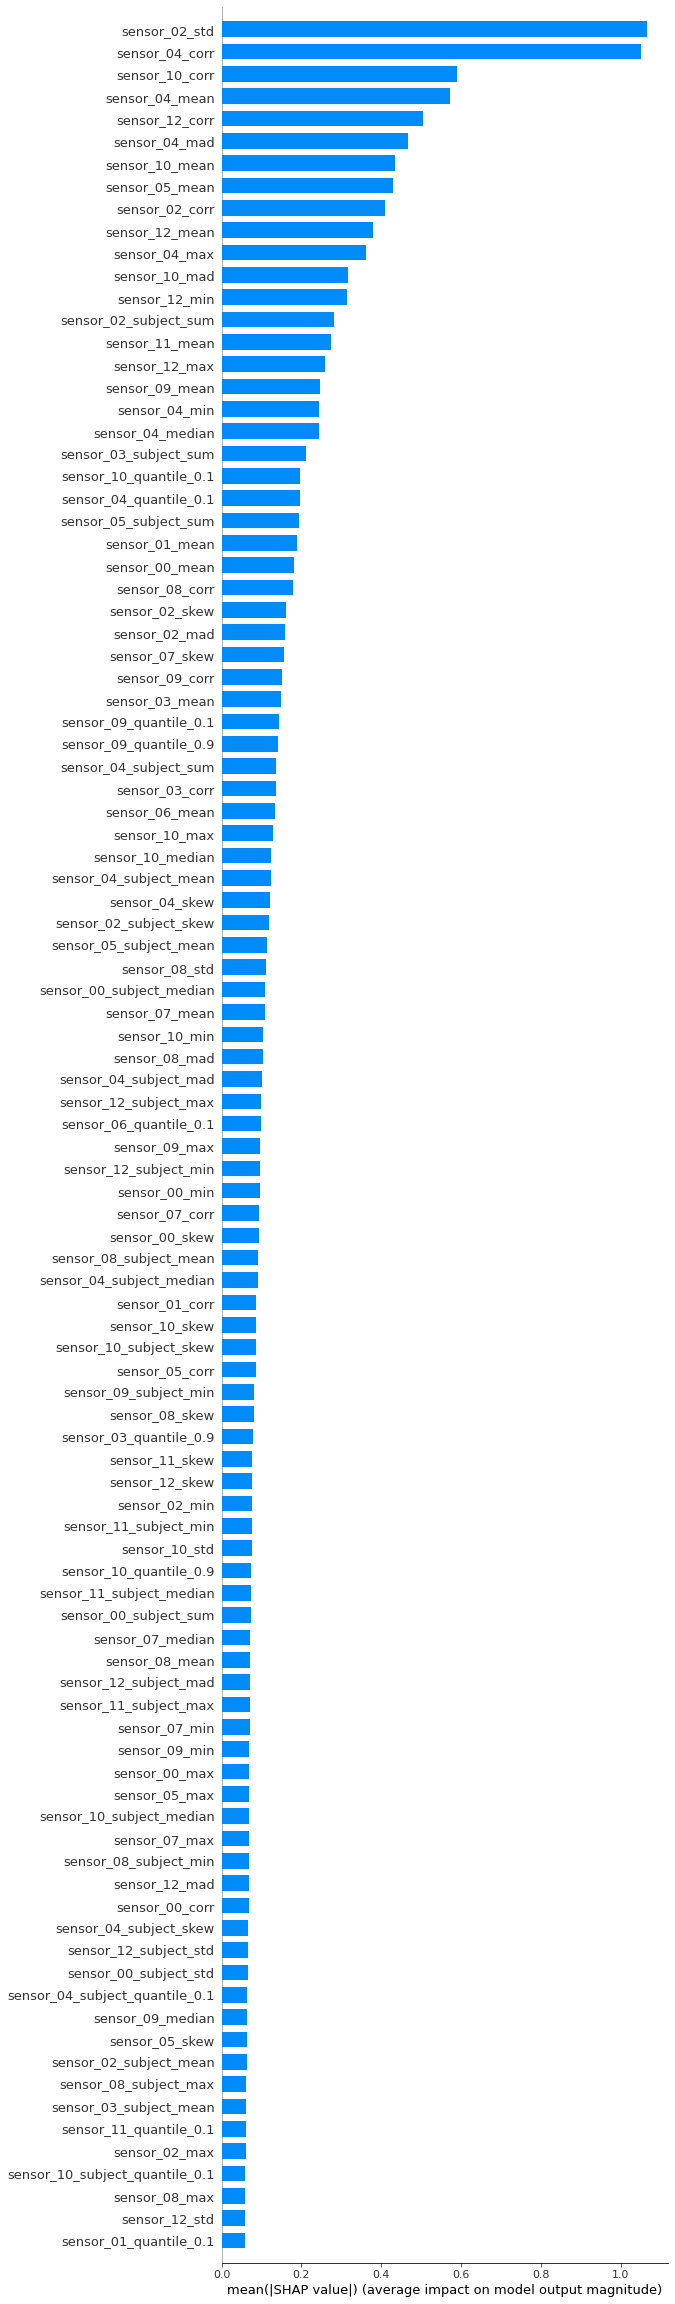

In [138]:
shap.summary_plot(shap_values, plot_type='bar', \
                  features=train.drop(columns=['sequence','subject','label']).columns, \
                  max_display=100)